In [1]:
import sys
sys.path.append('../../')

In [2]:
import data.loader

In [3]:
(train, train_y), (test, test_y), (_, _), one_hot_encoder_X, one_hot_encoder_y = data.loader.encode_and_partition(
    data.loader.diabetic_data_raw
)

In [4]:
train.shape[1]

2831

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import wandb
import os

wandb.init(project="ae", config={
    "learning_rate": 1e-3,
    "epochs": 40,
    "batch_size": 64,
    "hidden_dim": 128,
    "latent_dim": 64
})

wandb: Currently logged in as: charles-s-strauss (charles-s-strauss-n-a). Use `wandb login --relogin` to force relogin


In [6]:
from models.ae.model import AutoEncoder
!cp ./model.py $wandb.run.dir
wandb.save(os.path.join(wandb.run.dir, "model.py"))

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/scratch/u1319464/BMI6015-diabetes-final/models/ae/wandb/run-20241203_144531-txqgesvz/files/files/model.py']

In [10]:
input_dim = train.shape[1]
hidden_dim = wandb.config.hidden_dim
latent_dim = wandb.config.latent_dim
learning_rate = wandb.config.learning_rate
num_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size

model = AutoEncoder(input_dim, hidden_dim, latent_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

transform = transforms.Compose([transforms.ToTensor()])
train_data = torch.from_numpy(train.toarray().astype(np.float32))
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_data = torch.from_numpy(test.toarray().astype(np.float32))
test_dataset = TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
for batch in test_loader:
    test_eval_batch = batch[0].view(-1, input_dim)
    break

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for batch in train_loader:
        inputs = batch[0].view(-1, input_dim)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    model.eval()
    test_loss = criterion(model(test_eval_batch), test_eval_batch).item()
    wandb.log({"loss": avg_loss, "test_loss": test_loss})
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

torch.save(
    model.state_dict(),
    os.path.join(wandb.run.dir, "autoencoder.pth"))

artifact = wandb.Artifact("model", type="model")
artifact.add_file(os.path.join(wandb.run.dir, "autoencoder.pth"))
wandb.log_artifact(artifact)



Epoch [1/40], Loss: 0.0087
Epoch [2/40], Loss: 0.0048
Epoch [3/40], Loss: 0.0039
Epoch [4/40], Loss: 0.0032
Epoch [5/40], Loss: 0.0028
Epoch [6/40], Loss: 0.0025
Epoch [7/40], Loss: 0.0023
Epoch [8/40], Loss: 0.0022
Epoch [9/40], Loss: 0.0021
Epoch [10/40], Loss: 0.0020
Epoch [11/40], Loss: 0.0020
Epoch [12/40], Loss: 0.0020
Epoch [13/40], Loss: 0.0019
Epoch [14/40], Loss: 0.0019
Epoch [15/40], Loss: 0.0018
Epoch [16/40], Loss: 0.0018
Epoch [17/40], Loss: 0.0018
Epoch [18/40], Loss: 0.0018
Epoch [19/40], Loss: 0.0018
Epoch [20/40], Loss: 0.0018
Epoch [21/40], Loss: 0.0018
Epoch [22/40], Loss: 0.0017
Epoch [23/40], Loss: 0.0017
Epoch [24/40], Loss: 0.0017
Epoch [25/40], Loss: 0.0017
Epoch [26/40], Loss: 0.0017
Epoch [27/40], Loss: 0.0017
Epoch [28/40], Loss: 0.0017
Epoch [29/40], Loss: 0.0017
Epoch [30/40], Loss: 0.0017
Epoch [31/40], Loss: 0.0017
Epoch [32/40], Loss: 0.0017
Epoch [33/40], Loss: 0.0017
Epoch [34/40], Loss: 0.0017
Epoch [35/40], Loss: 0.0017
Epoch [36/40], Loss: 0.0017
E

<Artifact model>

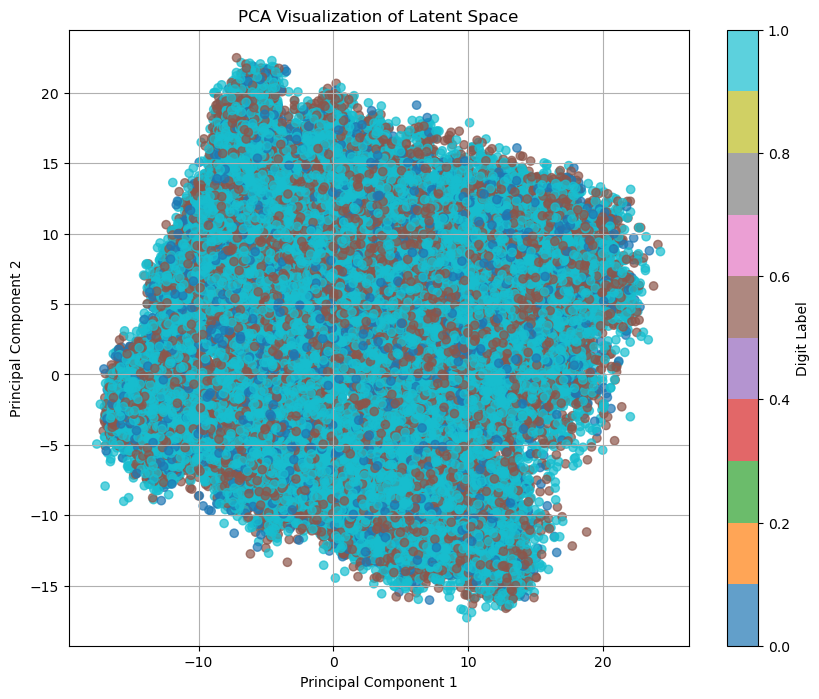

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def extract_latent_space(model, data_loader):
    model.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].view(-1, input_dim)
            encoded = model.encoder(inputs)
            latent_space.append(encoded)
    latent_space = torch.cat(latent_space).cpu().numpy()
    return latent_space

latent_space = extract_latent_space(model, train_loader)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_space)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=train_y.argmax(axis=-1)/2, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Digit Label")
plt.title("PCA Visualization of Latent Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()


In [12]:
wandb.run.log_code(".")  # Logs all code files in the current directory
wandb.finish()

loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,█▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00165
test_loss,0.0016
